<a href="https://colab.research.google.com/github/eyuuab/.java/blob/main/Frame_level_video_forgery_detaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Extracted 256 frames from the video.
Video FPS: 30.0


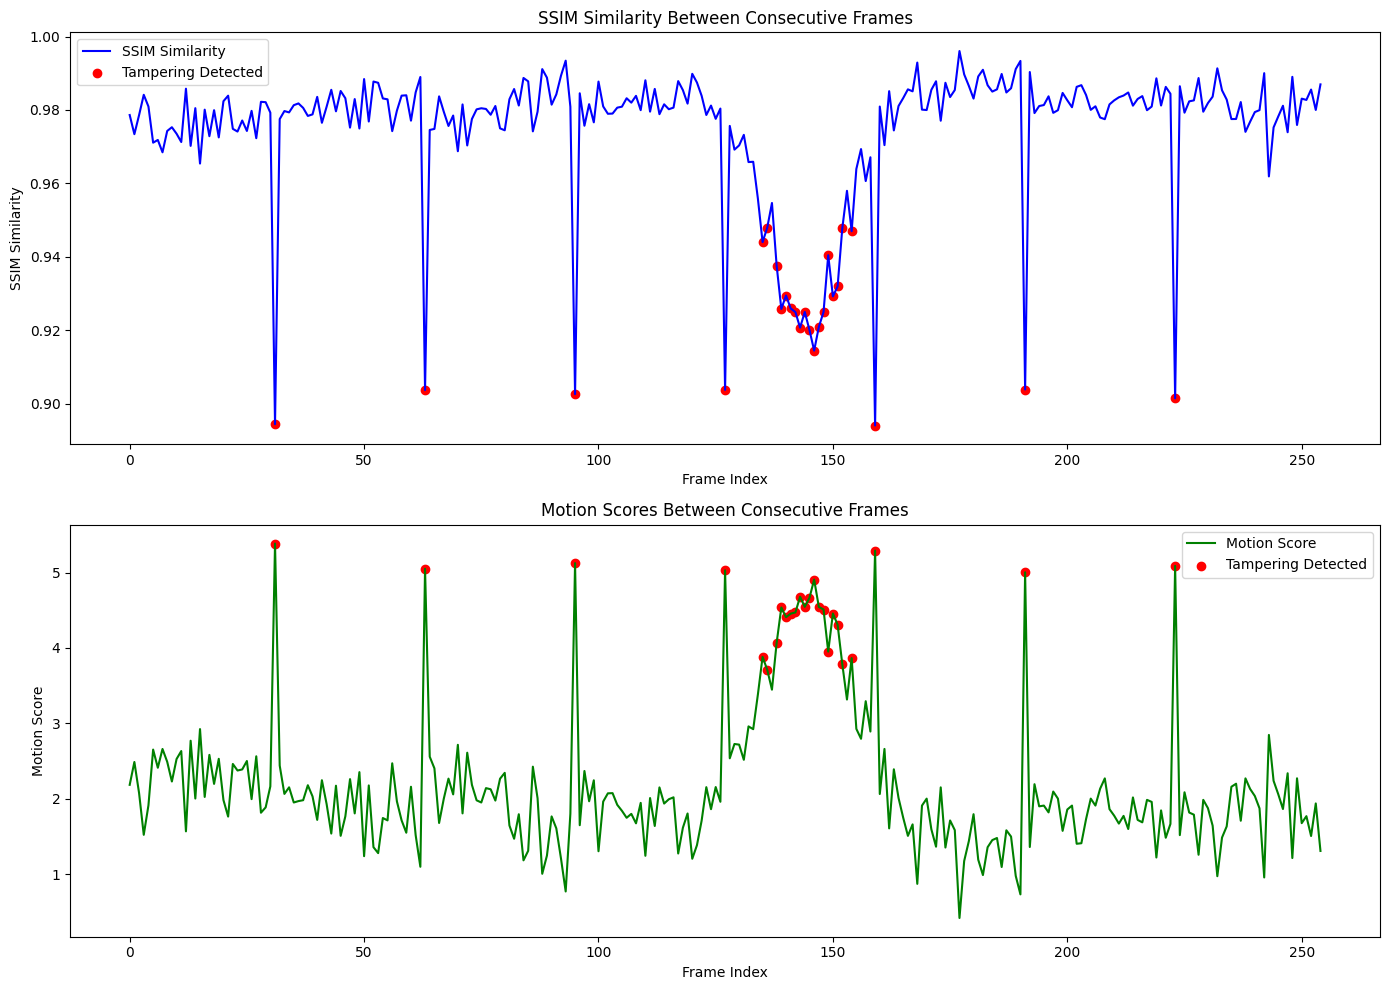

Total number of frames analyzed: 255
Total number of tampered frames detected: 25
Percentage of tampered frames: 9.80%
Standard Deviation of SSIM: 0.0190
Mean Motion Score: 2.1770
Standard Deviation of Motion Scores: 0.9249


In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

def extract_frames(video_path, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    cap = cv2.VideoCapture(video_path)
    frame_number = 0
    fps = cap.get(cv2.CAP_PROP_FPS)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_filename = os.path.join(output_folder, f'frame_{frame_number:04d}.jpg')
        cv2.imwrite(frame_filename, frame)
        frame_number += 1

    cap.release()
    print(f"Extracted {frame_number} frames from the video.")
    print(f"Video FPS: {fps}")

    return fps

def compute_frame_differences(frame_folder):
    frame_files = sorted([f for f in os.listdir(frame_folder) if f.endswith('.jpg')])
    differences = []
    motion_scores = []

    for i in range(1, len(frame_files)):
        prev_frame = cv2.imread(os.path.join(frame_folder, frame_files[i-1]))
        curr_frame = cv2.imread(os.path.join(frame_folder, frame_files[i]))

        gray_prev = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
        gray_curr = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
        score, _ = ssim(gray_prev, gray_curr, full=True)

        diff = cv2.absdiff(gray_prev, gray_curr)
        motion_score = np.mean(diff)

        differences.append(score)
        motion_scores.append(motion_score)

    return differences, motion_scores

def detect_tampering_combined(ssim_differences, motion_scores, ssim_threshold=0.95, motion_threshold=10):
    tampering_detected = []

    for ssim_diff, motion in zip(ssim_differences, motion_scores):
        if ssim_diff < ssim_threshold or motion > motion_threshold:
            tampering_detected.append(True)
        else:
            tampering_detected.append(False)

    return tampering_detected

def plot_tampering_advanced(ssim_differences, motion_scores, tampering_detected):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

    ax1.plot(ssim_differences, label="SSIM Similarity", color='blue')
    ax1.scatter(np.where(tampering_detected)[0], np.array(ssim_differences)[tampering_detected],
                color='red', label='Tampering Detected')
    ax1.set_title('SSIM Similarity Between Consecutive Frames')
    ax1.set_xlabel('Frame Index')
    ax1.set_ylabel('SSIM Similarity')
    ax1.legend()

    ax2.plot(motion_scores, label="Motion Score", color='green')
    ax2.scatter(np.where(tampering_detected)[0], np.array(motion_scores)[tampering_detected],
                color='red', label='Tampering Detected')
    ax2.set_title('Motion Scores Between Consecutive Frames')
    ax2.set_xlabel('Frame Index')
    ax2.set_ylabel('Motion Score')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Main workflow
video_path = '/content/Inpaint2.mp4'  # Replace with your video path
fps = extract_frames(video_path, 'extracted_frames')

ssim_differences, motion_scores = compute_frame_differences('extracted_frames')

tampering_detected = detect_tampering_combined(ssim_differences, motion_scores,
                                             ssim_threshold=0.95,
                                             motion_threshold=10)

plot_tampering_advanced(ssim_differences, motion_scores, tampering_detected)

num_tampered = sum(tampering_detected)
num_total = len(tampering_detected)

# Calculate standard deviations
ssim_std = np.std(ssim_differences)
motion_std = np.std(motion_scores)
mean_motion_score = np.mean(motion_scores)

# Print results
print(f"Total number of frames analyzed: {num_total}")
print(f"Total number of tampered frames detected: {num_tampered}")
print(f"Percentage of tampered frames: {100 * num_tampered / num_total:.2f}%")

print(f"Standard Deviation of SSIM: {ssim_std:.4f}")
print(f"Mean Motion Score: {mean_motion_score:.4f}")
print(f"Standard Deviation of Motion Scores: {motion_std:.4f}")
